# Example of using the trained CNN to classify galaxy-shred
#### Needed python packages:
1) Keras (tested with version 2.11)
2) Tensorflow
3) Numpy
4) Scipy
6) astropy
7) Joblib

In [1]:
# Importing all needed packages
import os, sys
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.table import Table
import astropy.units as u
from matplotlib import pyplot as plt

# Works with keras 2.11 and tensorflow 2.11
from tensorflow.keras.preprocessing import image
import keras 
print ("Keras version: ", keras.__version__)

# Following are needed just to download PNG cutouts
from joblib import Parallel, delayed
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm

2022-12-02 14:30:37.357746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keras version:  2.11.0


## Here we download directly grz images from Legacy in the right format for the CNN
##### Images have been already downloaded from an example catalog into the example_images directory, thus this section can be skipped and we can [directly classify them](#CNNexample)


In [2]:
# Loading a table with coordinates of objects to be classified. In this case, the catalog is from SDSS
cat = Table.read("example_catalog.fits")
print (f"Full catalog as {len(cat)} objects.")
cat[0:10]

Full catalog as 1000 objects.


<Table length=10>
       objID               ra               dec        
       int64            float64           float64      
------------------- ---------------- ------------------
1237662225157128528 228.852606775041   31.2177217291625
1237655493295407314 203.940483117684  -3.54974309348067
1237654604254937902 166.852728312342   3.82905840411997
1237661070333050957  175.67502163822   15.3549982847171
1237671125364835137 120.418240693836   8.78918799498331
1237661086952587678 116.909401703838   18.9868589638668
1237651753998352566  152.62012044424   2.23170546571096
1237671764249477212 191.289112505462 -0.456269217417459
1237661950802723186 211.329827965154   11.9837820277517
1237665331466404013  194.29379587091    33.049184003206

In [3]:
# Defining properties of images (here we download 60" PNG cutouts with 128 x 128 pixels each

bands = 'grz'                 # Photometric bands for the RGB image (g,r and z)
size = 60.*u.arcsec           # Angular size of each image 
imsize = 128                  # Size of each image in pixels
imdir = f"example_images"     # Directory where images will be written to

nthreads = 8                  # Number of threads to use to download images in parallel
overwrite = False             # Whether to overwrite existing files

if not os.path.exists(imdir): os.makedirs(imdir)

Name, RA, DEC = cat['objID'], cat['ra'], cat['dec']

In [4]:
# Two functions to retrieve image cutouts from the LEGACY server

def LEGACY_geturl(ra,dec,size,pixsize=0.262,filters="grz",fmt="jpg",dr='dr9'):
    
    """ Get URLs for LEGACY images
    
    Parameters
    ----------
    ra, dec (float) : position in degrees
    size (int)      : extracted image size in pixels
    pixsize (float) : pixel scale (default for LEGACY is 0.262 arcsec/pixel)
    filters (str)   : string with filters to include
    fmt (str)       : data format (options are "jpg", "jpeg","png" or "fits")
    dr (str)        : data_release (latest dr9)
    
    Returns a string with the URL
    """
        
    if fmt not in ("jpg","png","fits","jpeg"):
        raise ValueError(f"LEGACY format must be one of jpg, png, fits {format}")
    if fmt=="jpg" or fmt=="png": fmt="jpeg"
    
    if False in [b in ("g","r","z") for b in filters]:
        raise ValueError(f"LEGACY filters are g-r-z only")
    
    layer = f'ls-{dr}' if dr=='dr9' else dr
    
    url = f"http://legacysurvey.org/viewer/{fmt}-cutout?ra={ra}&dec={dec}&layer={layer}"
    url += f"&pixscale={pixsize}&bands={filters}&size={size}"
        
    return url


def LEGACY_getCutout(ra,dec,size,pixscale=0.262,filters="grz",fmt="fits",dr='dr9'):
    
    """ Get cutout image at a sky position with a given size
    
    Parameters
    ----------
    
    ra (float)       : Central RA coordinate in degrees
    dec (float)      : Central DEC coordinate in degrees
    size (int)       : Size of the final image(s) in pixel
    pixscale (float) : Pixel scale (default for LEGACY is 0.262 arcsec/pixel)
    filters (str)    : Filters to include (allowed values are g,r,z)
    fmt (str)        : Format of returned image (options are "jpg", "png", "fits", "all")
    dr (str)         : data_release (latest dr9)
    
    Returns the image(s). It is a astropy.fits or an array of astropy.fits if fmt="fits",
    a PIL.Image in the case of fmt="png,jpg" or both if fmt='all'.
    
    """
    RGBimage = myfits = None
    
    if fmt=="fits" or fmt=="all":
        myfits = []
        for b in filters:
            fitsurl = LEGACY_geturl(ra,dec,int(size),pixsize=pixscale,filters=b,fmt="fits",dr=dr)
            myfits.append(fits.open(fitsurl))
        if len(myfits)==1: myfits = myfits[0]
    
    if fmt!="fits":
        legfmt = "jpeg" if fmt=='all' else fmt
        url = LEGACY_geturl(ra,dec,int(size),pixsize=pixscale,filters=filters,fmt=legfmt,dr=dr)
        r = requests.get(url)
        RGBimage = Image.open(BytesIO(r.content))

    if fmt=='all': return myfits, RGBimage
    elif fmt=='fits': return myfits
    else: return RGBimage

In [5]:
# Now we download all images into the imdir

def download_thumbnail(i):
    if os.path.exists(f"{imdir}/{Name[i]}_{bands}.png") and not overwrite: return
    
    try:
        a = LEGACY_getCutout(RA[i],DEC[i],size=imsize,pixscale=size.value/imsize,filters=bands,fmt='png')
    except:    
        print (f"Couldn't find any image for {Name[i]} in LEGACY")
        return

    a.save(f"{imdir}/{Name[i]}_{bands}.png","PNG")
    return


if nthreads==1:      # Serial execution
    for i in tqdm(range(len(RA))): 
        download_thumbnail(i)
else:               # Parallel execution
    a = Parallel(n_jobs=nthreads,verbose=3)(delayed(download_thumbnail)(i) for i in range(len(RA)))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   46.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  6.0min finished


##
## Now we can classify our objects into "Galaxy" or "Shred"
<a id='CNNexample'></a>

In [6]:
# Defining an image generator with the images to classify

test_generator = image.ImageDataGenerator(rescale=1/255.)
testgen = test_generator.flow_from_directory('.',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=['example_images'], 
                                             shuffle=False,
                                             seed=42)

Found 4000 images belonging to 1 classes.


In [7]:
# Loading the trained CNN model
model = keras.models.load_model('CNN_shreds.dms')

2022-12-02 14:39:45.934780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Predicting classes (0 = Galaxy, 1 = Shred)
pp = model.predict(testgen)
predicted_classes = np.argmax(pp, axis=-1)

1435/4000 [=========>....................] - ETA: 53s

2022-12-02 14:40:19.168972: W tensorflow/core/framework/op_kernel.cc:1818] UNKNOWN: FileNotFoundError: [Errno 2] No such file or directory: './example_images/1237659324408529049_grz.png'
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1039, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 901, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 1048, in generator_fn
    yield x[i]

  File "/usr/local/lib/python3.10/site-packages/ke

UnknownError: Graph execution error:

FileNotFoundError: [Errno 2] No such file or directory: './example_images/1237659324408529049_grz.png'
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1039, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 901, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 1048, in generator_fn
    yield x[i]

  File "/usr/local/lib/python3.10/site-packages/keras/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/usr/local/lib/python3.10/site-packages/keras/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/usr/local/lib/python3.10/site-packages/keras/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: './example_images/1237659324408529049_grz.png'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_predict_function_2433]

In [ ]:
# Defining a function to plot some of the predicted classes
def plot_predictions(y_preds, test_generator):
    fig = plt.figure(figsize=(18, 15))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=30, replace=False)):
        ax = fig.add_subplot(5, 6, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]),extent=[-1,1,-1,1])
        pred_idx = y_preds[idx]
        ax.plot(0,0,'x',c='red',mew=1.5)
        plt.tight_layout()
        title = 'Shred' if y_preds[idx] else 'Galaxy'
        ax.set_title(title,color=("red" if pred_idx else "green"))

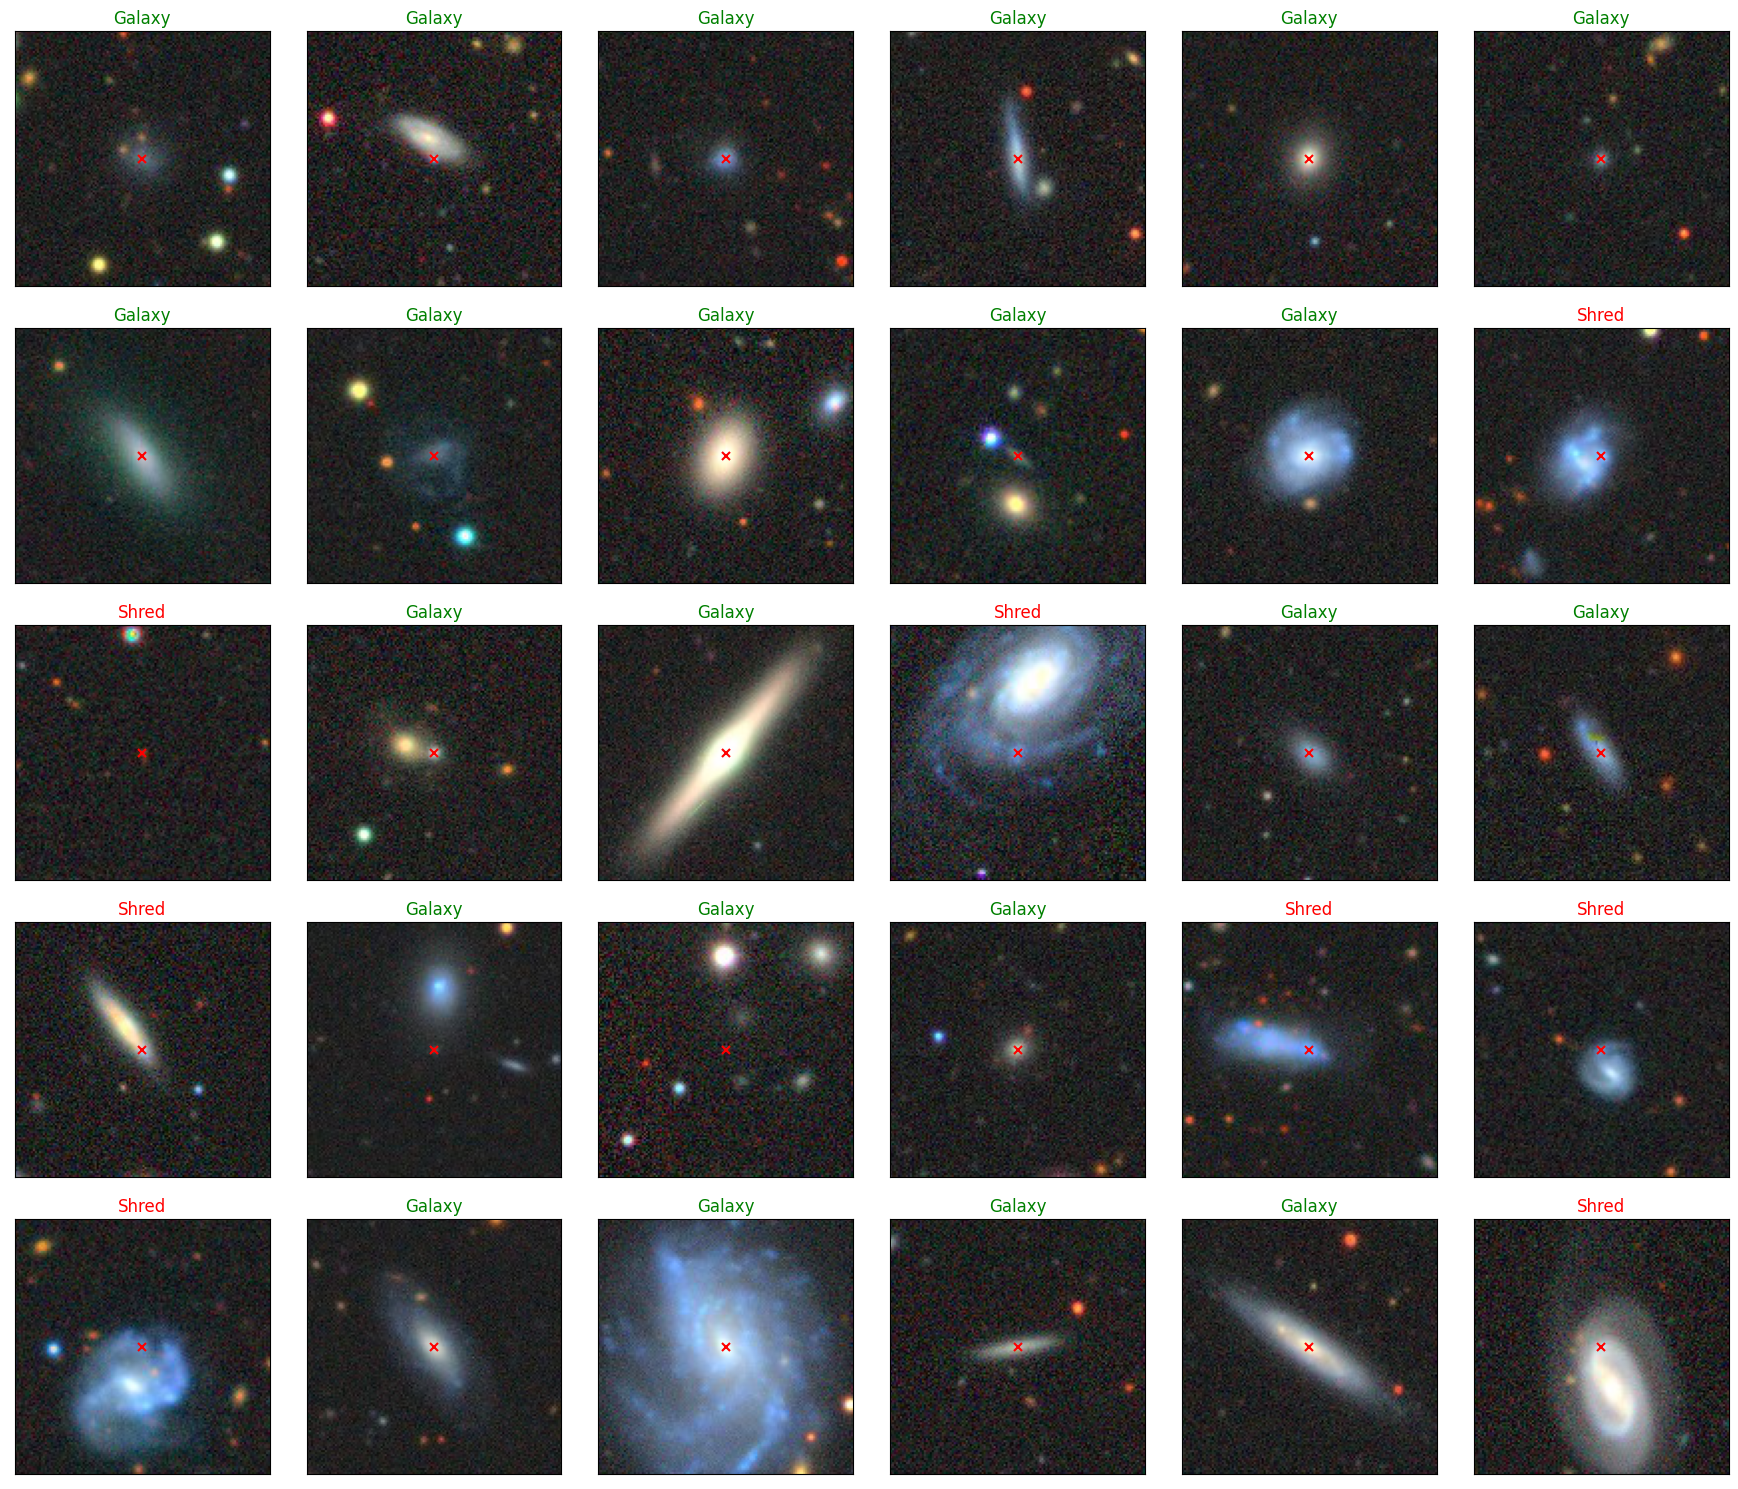

In [8]:
# Plotting a selection of 30 images with their predicted class
plot_predictions(predicted_classes, testgen)